In [21]:
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
# matplotlib.rcParams['figure.dpi'] = 80
matplotlib.rcParams['figure.figsize'] = [14, 6]
matplotlib.rcParams['axes.grid'] = True

In [22]:
%load_ext autoreload
%autoreload 2

import sys
sys.version_info

import sys
sys.path.insert(0, '../')


import numpy as np
import matplotlib.pyplot as plt

from lib_data import *

import random

from tqdm.notebook import tqdm
from lib_lsh import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
load_workspace(vars(), filename='25shot_may18')

Loaded: mem_vals, mem_keys, x, y, x_new, y_new, qs, qs_new, 


In [24]:
load_workspace(vars(), filename='20200619-172822-lsh-hardware-g-5-qs_hash')

Loaded: In, Out, mem_vals, mem_keys, x, y, x_new, y_new, qs, qs_new, hash_planes, hash_key, y_true, y_preds, i, qq, yy, q_hash, distance, g, q, qs_input, rand_vecs, vec_pos, vec_neg, out_pos, out_neg, output, g_true, output_soft, output_soft2, c, lin_cor_lsh, output_cor, qs_hash_new, qs_hash, 


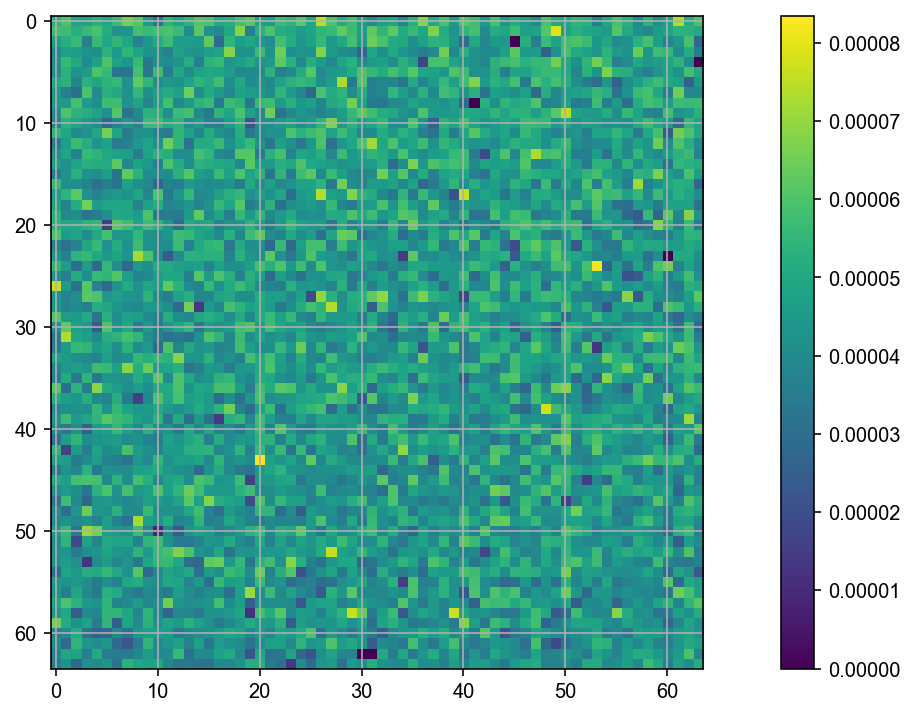

In [25]:
# g = dpe.read(0, method='slow')
plt.imshow(g)
plt.colorbar()

In [26]:
# hash_key = [get_lsh_g(k, g) for k in tqdm(mem_keys)]

# plt.imshow(np.array(hash_key))
# plt.colorbar()
# plt.grid(False)

In [114]:
y_true = []
y_preds= []

# qs_hash_new = []

for i, (q_hash, yy) in tqdm(enumerate(zip(qs_hash_new, y_new)), total=len(y_new)):
    if i==0:
        continue
        
#     q_hash = get_lsh_g(qq, g).reshape(-1)
#     qs_hash_new.append(q_hash)
    
    distance  = hamming(q_hash, hash_key)
    print(distance.argmin())
    y_pred = mem_vals[distance.argmin()]
    
    y_preds.append(y_pred)
    y_true.append(yy[0])
    
y_true = np.array(y_true)
y_preds= np.array(y_preds)

print(np.mean(y_true==y_preds))

59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
59
30
30
59

0.8947368421052632


In [233]:
y_true = []
y_preds= []

# qs_hash = []

for i, (q_hash, yy) in tqdm(enumerate(zip(qs_hash, y)), total=len(y)):
#     if i<125:
#         continue
    
    distance  = hamming(q_hash, hash_key)
    y_pred = mem_vals[distance.argmin()]
    
    y_preds.append(y_pred)
    y_true.append(yy[0])
    
y_true = np.array(y_true)
y_preds= np.array(y_preds)

print(np.mean(y_true==y_preds))


0.86


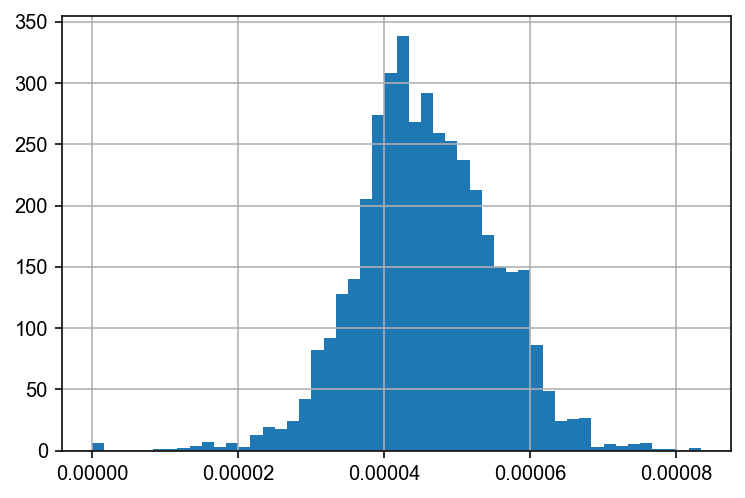

In [19]:
_ = plt.hist(g.reshape(-1), 50)

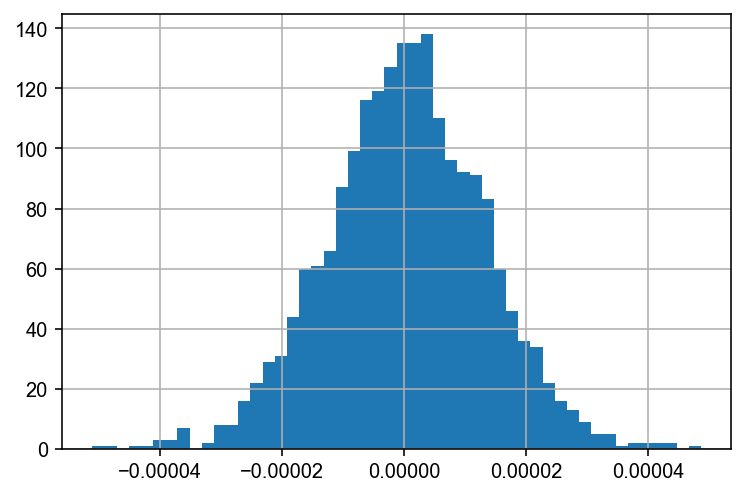

In [20]:
gdiff = g[:,::2] - g[:,1::2]

_ = plt.hist(gdiff.reshape(-1), 50)

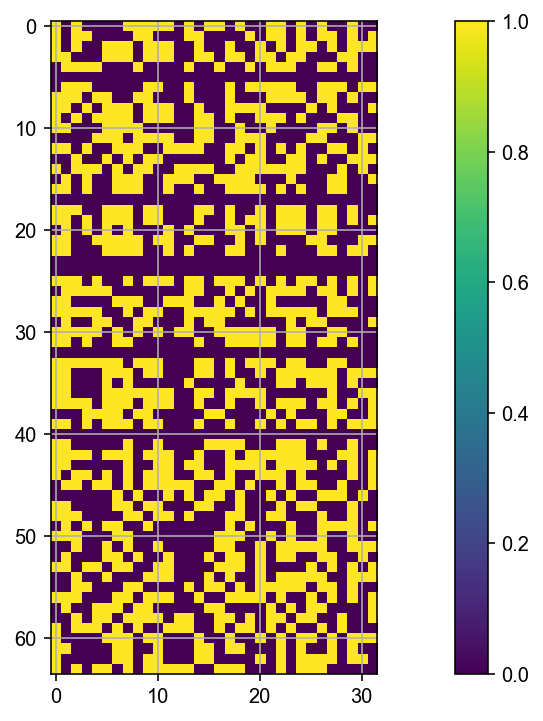

In [29]:
plt.imshow(hash_key); plt.colorbar()

In [128]:
from dpeTCAM import dpeTCAM, get_tcam_output

In [166]:
tcam = dpeTCAM(np.array(hash_key), g_std=0.0, rw=1e-12, g_on=100e-6, g_off=0e-6)

In [167]:
np.array(qs_hash_new).shape

(20, 32)

In [168]:
inp = tcam._gen_input_2r(qs_hash_new, v_read=1)

In [169]:
# res_dpe = tcam.compare(np.array(qs_hash_new))
res_dpe  = inp.T @ tcam.dpe.g_true

In [170]:
res_dpe.argmin(axis=1)

array([59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
       30, 30, 59], dtype=int64)

In [171]:
res_dpe = tcam.compare(np.array(qs_hash_new))
res_dpe.argmin(axis=1)

array([59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
       30, 30, 59], dtype=int64)

In [173]:
mem_vals[30]

22

# Program hash key

In [181]:
from dpe import DPE

dpe = DPE('COM9')
dpe.set_clock(50)

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


In [174]:
Gtarget = tcam.dpe.g_true
Msel = np.ones((64,64))

In [187]:
data = dpe.tune_conductance(2,  Gtarget, saveHistory=True, maxSteps=1000, method='slow',
                           vSetRamp=[1, 3, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 1.5, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=1e-3,  Msel=Msel, Gtol_in=4e-6, Gtol_out=10e-6, numReads=1)

Start programming, step=254, maxBound=1297 yield= 50.59% - 75.22%
10.0 devices to be programmed...reset 44.0, set 1261.0
Setting 130 devices...
Programming with external timing Twidth=10.000 us
Resetting 5 devices...
Programming with external timing Twidth=1000.000 us
..------------------------------
Programming completed.


....

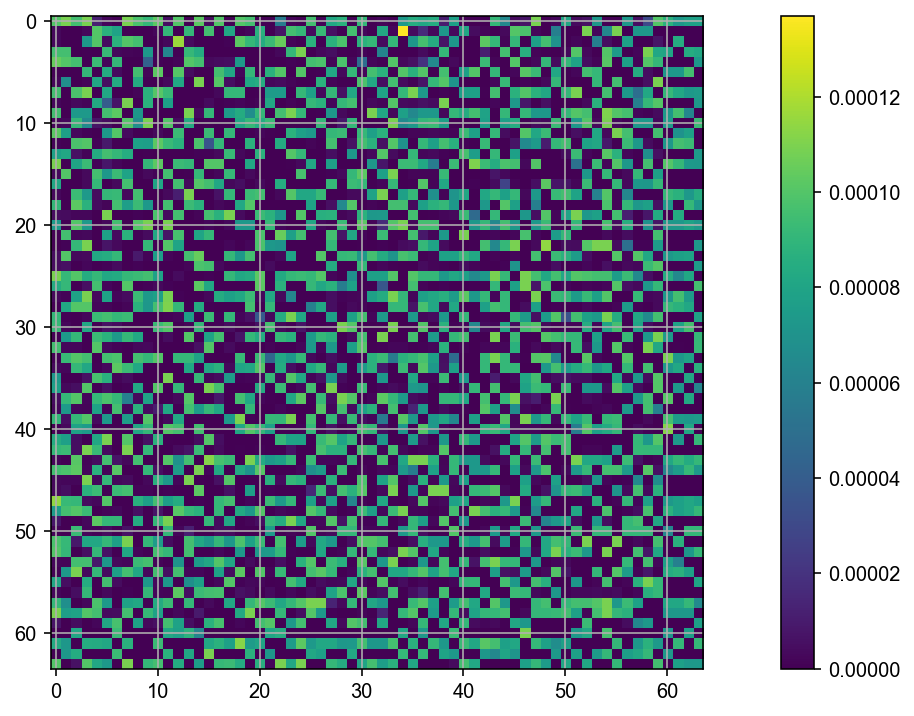

In [189]:
g = dpe.read(2, method='slow')
plt.imshow(g)
plt.colorbar()

In [190]:
g_hash = g.copy()

In [192]:
inp_new = tcam._gen_input_2r(qs_hash_new, v_read=1)
inp = tcam._gen_input_2r(qs_hash, v_read=1)

In [194]:
out_dpe= dpe.multiply(
            2, 
            inp, 
            c_sel=[0, 64], 
            r_start=0, mode=0, Tdly=500)

In [200]:
output_soft = inp.T @ tcam.dpe.g_true

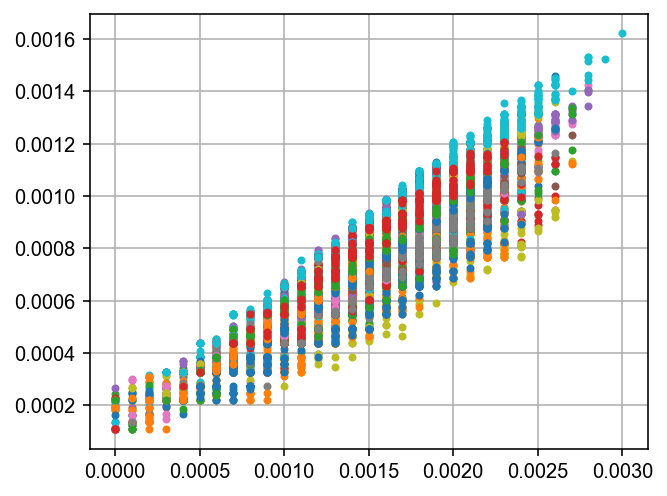

In [210]:
plt.figure(figsize=(5,4))

for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], out_dpe[:,c], '.')

In [216]:
lin_cor_tcam = []
for c in range(output.shape[1]):
    lin_cor_tcam.append( np.polyfit(out_dpe[:,c], output_soft[:,c], 1))
    
output_cor = dpe.lin_corr(out_dpe, lin_cor_tcam)

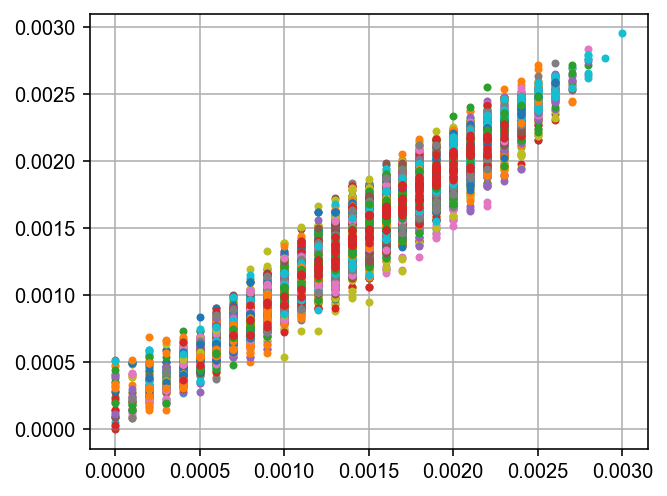

In [217]:
plt.figure(figsize=(5,4))

for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output_cor[:,c], '.')

In [230]:
output_cor = dpe.lin_corr(out_dpe, lin_cor_tcam)
idx = output_cor.argmin(axis=1)

In [231]:
y_true = []
y_preds= []

for n, (i, yy )in enumerate(zip(idx, y)):
    if n<125:
        continue
    
    y_pred = mem_vals[i]
    
    y_preds.append(y_pred)
    y_true.append(yy[0])
    
y_true = np.array(y_true)
y_preds= np.array(y_preds)

print(np.mean(y_true==y_preds))

0.7813333333333333


# New data

In [225]:
out_dpe_new= dpe.multiply(
            2, 
            inp_new, 
            c_sel=[0, 64], 
            r_start=0, mode=0, Tdly=500)

In [226]:
output_cor_new = dpe.lin_corr(out_dpe_new, lin_cor_tcam)

In [228]:
idx = output_cor_new.argmin(axis=1)

y_true = []
y_preds= []

for n, (i, yy) in enumerate(zip(idx, y_new)):
    if n==1:
        continue
        
    y_pred = mem_vals[i]
    
    y_preds.append(y_pred)
    y_true.append(yy[0])
    
y_true = np.array(y_true)
y_preds= np.array(y_preds)

print(np.mean(y_true==y_preds))

0.8947368421052632


In [232]:
save_workspace(vars(), note='tcam_experiment_0619nb')

Saving In(<class 'list'>), Out(<class 'dict'>), mem_vals(<class 'numpy.ndarray'>), mem_keys(<class 'numpy.ndarray'>), x(<class 'list'>), y(<class 'list'>), x_new(<class 'list'>), y_new(<class 'list'>), qs(<class 'list'>), qs_new(<class 'list'>), hash_planes(<class 'numpy.ndarray'>), hash_key(<class 'list'>), y_true(<class 'numpy.ndarray'>), y_preds(<class 'numpy.ndarray'>), qq(<class 'numpy.ndarray'>), yy(<class 'numpy.ndarray'>), q_hash(<class 'numpy.ndarray'>), distance(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), q(<class 'numpy.ndarray'>), qs_input(<class 'numpy.ndarray'>), rand_vecs(<class 'numpy.ndarray'>), vec_pos(<class 'numpy.ndarray'>), vec_neg(<class 'numpy.ndarray'>), out_pos(<class 'numpy.ndarray'>), out_neg(<class 'numpy.ndarray'>), output(<class 'numpy.ndarray'>), g_true(<class 'numpy.ndarray'>), output_soft(<class 'numpy.ndarray'>), output_soft2(<class 'numpy.ndarray'>), c(<class 'int'>), lin_cor_lsh(<class 'list'>), output_cor(<class 'numpy.ndarray'>), qs_hash